In [1]:
import sys
import os
import xarray as xr
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
import numpy as np
from isca_tools.utils.land import get_ocean_coords, get_land_coords
from isca_tools.utils import area_weighting, lat_lon_slice
from isca_tools.land import write_land
from isca_tools.sst import write_sst

2024-07-22 20:31:13,713 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


## Write SST file
Take annual average of previous 5m depth experiment, take annual average so can use these fixed SSTs in new experiment.

In [2]:
# Load in SSTs from previous simulation, and take annual average to get SSTs to use
sst_file = 'tau_sweep/aquaplanet/k=1/'
use_time_start = 360*2
sst_use = isca_tools.load_dataset(sst_file)['t_surf']
sst_use = sst_use.sel(time=slice(use_time_start, np.inf))
sst_use = sst_use.mean(dim='time').load()

In [28]:
isca_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/'
exp_dir = 'rossbypalooza/vary_rot_rate/1/'
write_sst(isca_path+exp_dir+'sst', isca_path+exp_dir+'namelist.nml', sst_use.to_numpy())

ValueError: The file /Users/joshduffield/Documents/StAndrews/Isca/jobs/rossbypalooza/vary_rot_rate/1/sst.nc already exists. Delete or re-name this to continue.

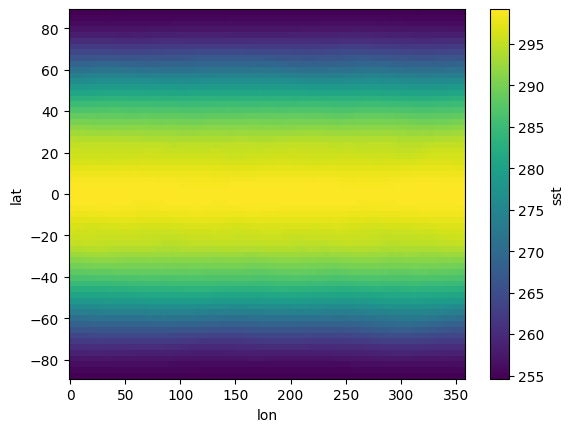

In [9]:
sst_saved = xr.load_dataset(isca_path+exp_dir+'sst.nc')
sst_saved.sst.plot()

## Create land
Create zonal strip of land in mid latitude to keep peak temperature near this region as vary rotation rate.

In [19]:
lat_min = 20
lat_max = 60
write_land(isca_path+exp_dir+'land', isca_path+exp_dir+'namelist.nml', 'square', [20, 60, 0-10, 360+10])

Output written to: /Users/joshduffield/Documents/StAndrews/Isca/jobs/rossbypalooza/vary_rot_rate/1/land.nc


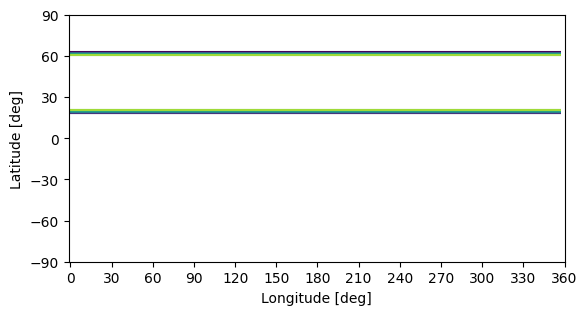

In [20]:
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, 'land.nc')
isca_tools.plot.show_land(land_file_name)

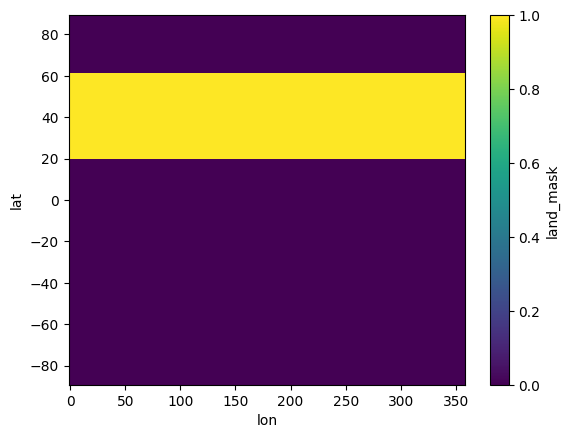

In [27]:
xr.load_dataset(land_file_name).land_mask.plot()